In [78]:
from util import load_data

name = 'yelp_reviews'

dataframes, relationships = load_data()
target_entity = "review"

entity_col = "business_id"
time_col = "date"

window_size = None
minimum_data = "2011-01-01"
maximum_data = dataframes["review"][0]["date"].max()

### Load data

In [79]:
from trane.parsing import denormalize
import pandas as pd

df = denormalize(
    dataframes,
    relationships,
    target_entity
)
df = df.drop(["business.categories", "business.neighborhoods"], axis=1)
df = df.dropna()

## Trane

#### Generate prediction problems

In [80]:
from trane import CutoffStrategy
from util import get_meta

meta = get_meta(df, entity_col)

cutoff_strategy = CutoffStrategy(
    entity_col=entity_col,
    window_size=window_size,
    minimum_data=minimum_data,
    maximum_data=maximum_data,
)

from trane import PredictionProblemGenerator
problem_generator = PredictionProblemGenerator(
    df=df,
    table_meta=meta,
    entity_col=entity_col,
    cutoff_strategy=cutoff_strategy,
    time_col=time_col,
)
problems = problem_generator.generate(df, generate_thresholds=True)

  0%|          | 0/15251 [00:00<?, ?it/s]

Find a relevant problem

In [81]:
with open("generated_problems.txt", "w") as text_file:
    for idx, p in enumerate(problems):
        print(idx, p, file=text_file)

In [84]:
df = df.sort_values("date")

In [85]:
ex = problems[138].execute(df, num_examples_per_instance=1)
problems[138]

Elapsed: 00:01 | Remaining: 00:00 | Progress: 100%|██████████| business_id: 699/699 


For each <business_id> predict the total <user.votes_useful> in all related records in next None days

#### Generate features

In [88]:
import sys, os
del sys.modules["featuretools_util"]
del get_features

from featuretools_util import get_features

X, y, es = get_features(
    name=name,
    df=df,
    target_entity=target_entity,
    entity_col=entity_col,
    time_index=time_col,
    relationships=relationships,
    cutoff_time=ex
)

X.head()

/opt/miniconda3/envs/trane2/lib/python3.10/site-packages/featuretools/entityset/entityset.py:754: UserWarning: A Woodwork-initialized DataFrame was provided, so the following parameters were ignored: index, time_index
  warnings.warn(
/opt/miniconda3/envs/trane2/lib/python3.10/site-packages/woodwork/column_schema.py:191: DuplicateTagsWarning: Semantic tag(s) 'foreign_key' already present on column 'business_id'
  warnings.warn(


Built 84 features
Elapsed: 00:12 | Progress: 100%|██████████


,business.checkin.type,business.full_address,business.open,business.city,business.review_count,business.name,business.longitude,business.state,business.stars,business.latitude,business.type,COUNT(review),MAX(review.stars),MAX(review.votes_cool),MAX(review.votes_funny),MAX(review.votes_useful),MEAN(review.stars),MEAN(review.votes_cool),MEAN(review.votes_funny),MEAN(review.votes_useful),MIN(review.stars),MIN(review.votes_cool),MIN(review.votes_funny),MIN(review.votes_useful),MODE(review.text),MODE(review.type),MODE(review.user_id),NUM_UNIQUE(review.text),NUM_UNIQUE(review.type),NUM_UNIQUE(review.user_id),SKEW(review.stars),SKEW(review.votes_cool),SKEW(review.votes_funny),SKEW(review.votes_useful),STD(review.stars),STD(review.votes_cool),STD(review.votes_funny),STD(review.votes_useful),SUM(review.stars),SUM(review.votes_cool),SUM(review.votes_funny),SUM(review.votes_useful),MAX(review.user.user.average_stars),MAX(review.user.user.review_count),MAX(review.user.user.votes_cool),MAX(review.user.user.votes_funny),MAX(review.user.user.votes_useful),MEAN(review.user.user.average_stars),MEAN(review.user.user.review_count),MEAN(review.user.user.votes_cool),MEAN(review.user.user.votes_funny),MEAN(review.user.user.votes_useful),MIN(review.user.user.average_stars),MIN(review.user.user.review_count),MIN(review.user.user.votes_cool),MIN(review.user.user.votes_funny),MIN(review.user.user.votes_useful),MODE(review.DAY(date)),MODE(review.MONTH(date)),MODE(review.WEEKDAY(date)),MODE(review.YEAR(date)),MODE(review.user.user.name),MODE(review.user.user.type),NUM_UNIQUE(review.DAY(date)),NUM_UNIQUE(review.MONTH(date)),NUM_UNIQUE(review.WEEKDAY(date)),NUM_UNIQUE(review.YEAR(date)),NUM_UNIQUE(review.user.user.name),NUM_UNIQUE(review.user.user.type),SKEW(review.user.user.average_stars),SKEW(review.user.user.review_count),SKEW(review.user.user.votes_cool),SKEW(review.user.user.votes_funny),SKEW(review.user.user.votes_useful),STD(review.user.user.average_stars),STD(review.user.user.review_count),STD(review.user.user.votes_cool),STD(review.user.user.votes_funny),STD(review.user.user.votes_useful),SUM(review.user.user.average_stars),SUM(review.user.user.review_count),SUM(review.user.user.votes_cool),SUM(review.user.user.votes_funny),SUM(review.user.user.votes_useful)
0,checkin,"9008 N 99th Ave\nPeoria, AZ 85345",True,Peoria,4,Nino's Pizzeria 2,-112.276615,AZ,4.0,33.566264,business,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,<NA>,<NA>,<NA>,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.00,0.0,0.0,0.0,0.0
1,checkin,"2613 N Scottsdale Rd\nScottsdale, AZ 85257",True,Scottsdale,255,D'lish,-111.925799,AZ,4.5,33.477178,business,65,5.0,13.0,18.0,14.0,4.230769,1.969231,1.676923,2.446154,2.0,0.0,0.0,0.0,"$10.50 got me a 16oz hot, dirty chai and chef ...",review,0bNXP9quoJEgyVZu9ipGgQ,65,1,65,-1.034885,2.217033,3.039285,2.361487,0.785995,2.828257,3.288748,3.211458,275.0,128.0,109.0,159.0,5.0,1325.0,14381.0,13074.0,16707.0,3.908923,182.384615,897.969231,791.723077,1101.646154,2.33,3.0,0.0,0.0,0.0,13,12,0,2009,Christy,user,27,12,7,4,61,1,-0.391970,2.439481,3.837603,4.041084,3.808330,0.446945,293.303474,2474.882737,2288.361583,2846.623962,254.08,11855.0,58368.0,51462.0,71607.0
2,checkin,"408 E Roosevelt St\nPhoenix, AZ 85004",True,Phoenix,12,Phoenix Food Truck Festival,-112.068175,AZ,2.0,33.459023,business,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,<NA>,<NA>,<NA>,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.00,0.0,0.0,0.0,0.0
3,checkin,"2800 W Chandler Blvd\nChandler, AZ 85224",True,Chandler,42,Mimis Cafe,-111.893070,AZ,3.5,33.306411,business,20,5.0,4.0,6.0,6.0,3.800000,0.600000,0.800000,1.100000,2.0,0.0,0.0,0.0,Crowded on 

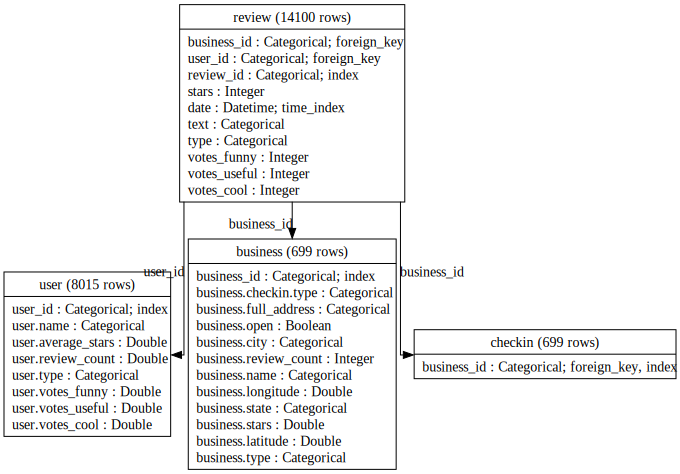

In [89]:
es.plot()

### AutoML

#### BTB

In [90]:
from baytune_util import automl

automl(X, y)

  0%|          | 0/10 [00:00<?, ?it/s]

/opt/miniconda3/envs/trane2/lib/python3.10/site-packages/sklearn/model_selection/_split.py:725: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001389 seconds.
You can set `force_col_wise=true` to remove the overhead.[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002513 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001429 seconds.
You can set `force_col_wise=true` to remove the overhead.


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001936 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5097[LightGBM] [Info] Total Bins 5094

[LightGBM] [Info] Total Bins 5033
[LightGBM] [Info] Total Bins 5036
[LightGBM] [Info] Number of data points in the train set: 544, number of used features: 81
[LightGBM] [Info] Number of data points in the tr

/opt/miniconda3/envs/trane2/lib/python3.10/site-packages/sklearn/model_selection/_split.py:725: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
/opt/miniconda3/envs/trane2/lib/python3.10/site-packages/sklearn/model_selection/_split.py:725: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
/opt/miniconda3/envs/trane2/lib/python3.10/site-packages/sklearn/model_selection/_split.py:725: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
/opt/miniconda3/envs/trane2/lib/python3.10/site-packages/sklearn/model_selection/_split.py:725: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
/opt/miniconda3/envs/trane2/lib/python3.10/site-packages/sklearn/model_selection/_split.py:725: UserWarning: The least populated class in y has only 1 members, which is

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001430 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5036
[LightGBM] [Info] Number of data points in the train set: 544, number of used features: 81
[LightGBM] [Info] Start training from score 2715.301471
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001763 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4999
[LightGBM] [Info] Number of data points in the train set: 544, number of used features: 81
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Start training from score 3062.343750
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning

/opt/miniconda3/envs/trane2/lib/python3.10/site-packages/sklearn/model_selection/_split.py:725: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
/opt/miniconda3/envs/trane2/lib/python3.10/site-packages/sklearn/model_selection/_split.py:725: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(


[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001659 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5033
[LightGBM] [Info] Number of data points in the train set: 544, number of used features: 81
[LightGBM] [Info] Start training from score 3034.591912
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002609 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5094
[LightGBM] [Info] Number of data points in the train set: 544, number of used features: 81
[LightGBM] [Info] Start training from score 2927.112132
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000833 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Inf

/opt/miniconda3/envs/trane2/lib/python3.10/site-packages/sklearn/model_selection/_split.py:725: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000805 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5033
[LightGBM] [Info] Number of data points in the train set: 544, number of used features: 81
[LightGBM] [Info] Start training from score 3034.591912
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overh

/opt/miniconda3/envs/trane2/lib/python3.10/site-packages/sklearn/model_selection/_split.py:725: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(


[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001333 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5033
[LightGBM] [Info] Number of data points in the train set: 544, number of used features: 81
[LightGBM] [Info] Start training from score 3034.591912
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003673 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5094
[LightGBM] [Info] Number of data points in the train set: 544, number of used features: 81
[LightGBM] [Info] Start training from score 2927.112132
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001957 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Inf

{'id': '2343e282685d567d966400b303f819f0',
 'name': 'LGB',
 'config': {'num_leaves': 2,
  'max_depth': 3,
  'learning_rate': 0.01,
  'n_estimators': 10},
 'score': 28758714.216949783}